Collaborative Filtering with Truncated SVD - RMSE: 0.3465
Collaborative Filtering with Truncated SVD - MAE: 0.2774
Collaborative Filtering with Truncated SVD - R^2 Score: -0.9117

Top Recommended Accommodations for You:
      item  predicted_rating
18      19          3.145118
1569  1570          3.138420
881    882          3.127550
723    724          3.108606
35      36          3.054411


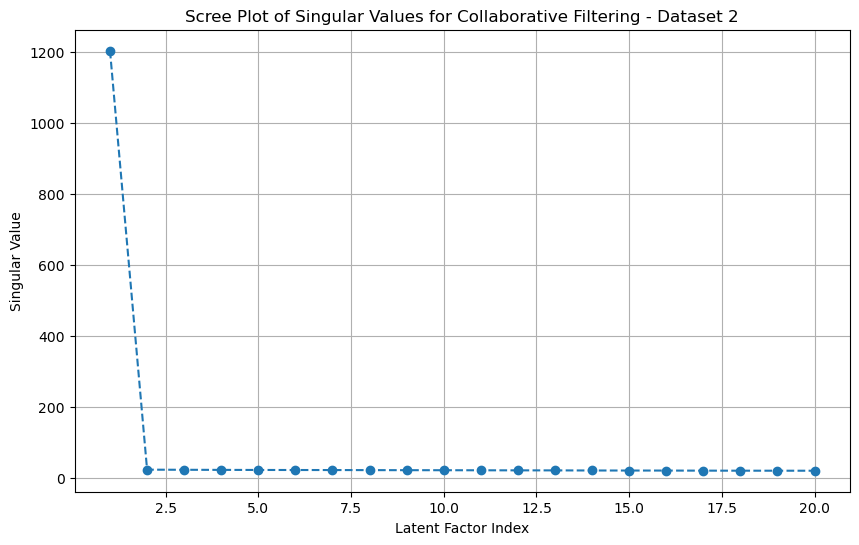

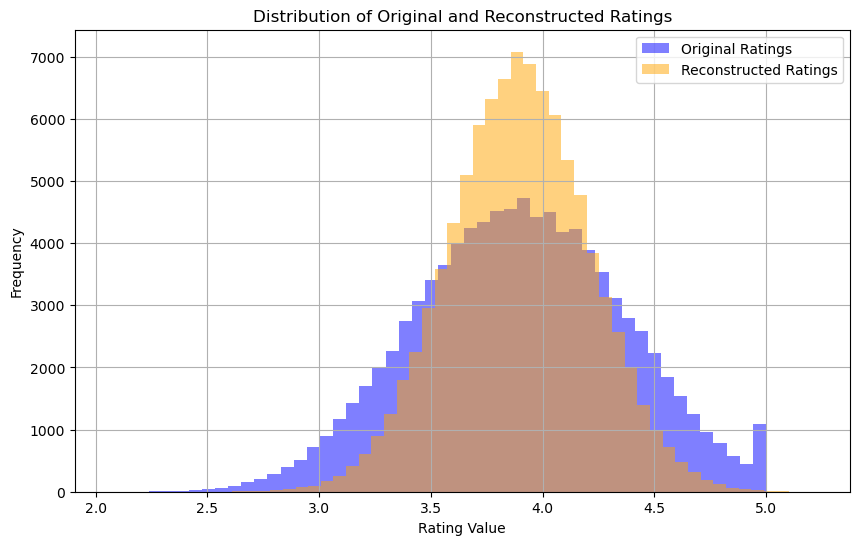

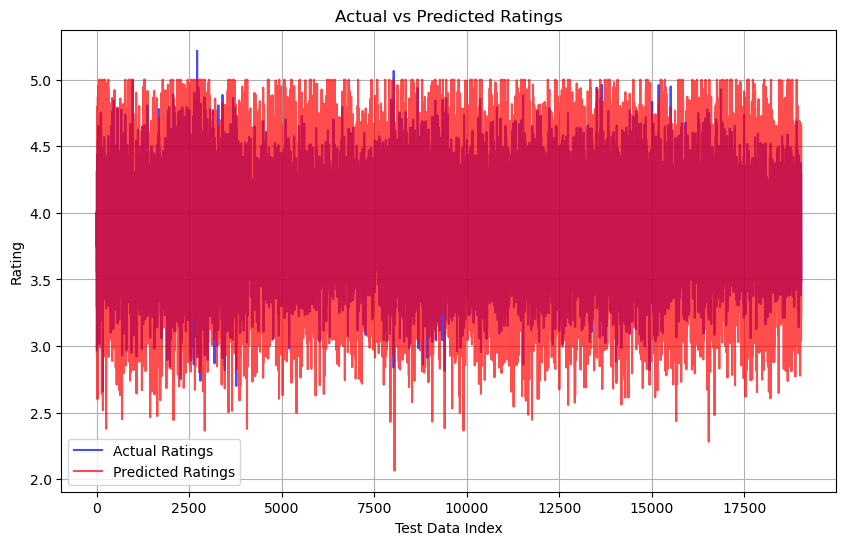

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

user_ratings_df = pd.read_csv('user_ratings_accommodations.csv')

user_ratings_df = user_ratings_df.groupby(['User_ID', 'Accommodation_ID']).agg({'User_Rating': 'mean'}).reset_index()

num_users = user_ratings_df['User_ID'].nunique()
num_items = user_ratings_df['Accommodation_ID'].nunique()

user_item_matrix = user_ratings_df.pivot(index='User_ID', columns='Accommodation_ID', values='User_Rating').fillna(0).values
user_item_matrix = csr_matrix(user_item_matrix)

n_components = 20 
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_item_reduced = svd.fit_transform(user_item_matrix)

user_item_approx = svd.inverse_transform(user_item_reduced)

X_train, X_test, y_train, y_test = train_test_split(user_item_matrix.toarray(), user_item_approx, test_size=0.2, random_state=42)

rmse_svd = np.sqrt(mean_squared_error(y_test, X_test))
mae_svd = mean_absolute_error(y_test, X_test)
r2_svd = r2_score(y_test, X_test)

print(f"Collaborative Filtering with Truncated SVD - RMSE: {rmse_svd:.4f}")
print(f"Collaborative Filtering with Truncated SVD - MAE: {mae_svd:.4f}")
print(f"Collaborative Filtering with Truncated SVD - R^2 Score: {r2_svd:.4f}")

def recommend_items(user_preferences, df, svd, num_recommendations=5):
    user_latent = svd.transform([user_preferences])
    user_approx_ratings = svd.inverse_transform(user_latent).flatten()

    recommendations = pd.DataFrame({'item': df['Accommodation_ID'].unique(), 'predicted_rating': user_approx_ratings})
    recommended_items = recommendations.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    return recommended_items

user_preferences = [np.random.uniform(0, 5) for _ in range(num_items)]

top_recommended_items = recommend_items(user_preferences, user_ratings_df, svd)

print("\nTop Recommended Accommodations for You:")
print(top_recommended_items[['item', 'predicted_rating']])


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), svd.singular_values_, marker='o', linestyle='--')
plt.xlabel('Latent Factor Index')
plt.ylabel('Singular Value')
plt.title('Scree Plot of Singular Values for Collaborative Filtering - Dataset 2')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(user_item_matrix.toarray().flatten(), bins=50, alpha=0.5, label='Original Ratings', color='blue')
plt.hist(user_item_approx.flatten(), bins=50, alpha=0.5, label='Reconstructed Ratings', color='orange')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Reconstructed Ratings')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
x_values = range(len(y_test.flatten()))
plt.plot(x_values, y_test.flatten(), label='Actual Ratings', alpha=0.7, color='blue')
plt.plot(x_values, X_test.flatten(), label='Predicted Ratings', alpha=0.7, color='red')
plt.xlabel('Test Data Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()
